Importing what needs to be imported:

In [1]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt  
import numpy as np
import seaborn as sns

This file needed to be downloaded directly.  We couldn't find a way to access it through the API, so we grabbed the csv and just worked on it directly.  We found it at http://inalitic.com/datasets/nhl%20player%20data.html.  There was an issue with the encoding not being utf-8 that we had to correct.

In [2]:
df = pd.read_csv('skater_stats.csv', encoding='latin1')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# New API

In [3]:
# Initializing varibables
teamgoalsdict = {}
yeardict = {}
listofgoalgpgBefore = []
listofgoalgpgAfter = []

# The ten seasons prior to the rule changes
seasonindices = ['19931994', '19941995', '19951996', '19961997', '19971998', '19981999', '19992000', '20002001', '20012002', '20022003']

# This for loop makes an API call for each season and then 
# puts each team's GPG into a list
for index in seasonindices:
#     print(index)
    yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=' + index
    r = requests.get(yearhtml, auth=('user', 'pass'))
    nestdict = r.json()
    for i in range(len(nestdict['teams'])):
#         name = nestdict['teams'][i]['teamStats'][0]['splits'][0]['team']['name']
        goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
        listofgoalgpgBefore.append(goalsPerGame)

# The ten seasons after the rule changes
seasonindicesaft = ['20062007', '20072008', '20082009', '20092010', '20102011', '20112012', '20122013', '20132014', '20142015', '20152016']

# This for loop makes an API call for each season and then 
# puts each team's GPG into a list
for index in seasonindicesaft:
#     print(index)
    yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=' + index
    r = requests.get(yearhtml, auth=('user', 'pass'))
    nestdict = r.json()
    for i in range(len(nestdict['teams'])):
#         name = nestdict['teams'][i]['teamStats'][0]['splits'][0]['team']['name']
        goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
        listofgoalgpgAfter.append(goalsPerGame)                

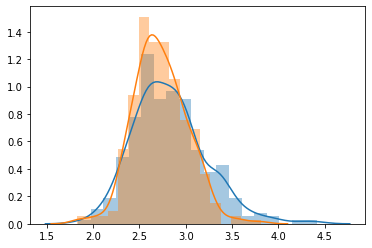

In [4]:
# Quick plot - eda
sns.distplot(listofgoalgpgBefore)
sns.distplot(listofgoalgpgAfter)

For relatively normal graphs, the mean should equal the median.  This is just a quick and dirty way of determining normality.  Probably not the best way, but should be good enough.

In [5]:
np.mean(np.array(listofgoalgpgAfter))/np.median(np.array(listofgoalgpgAfter))

1.0070877970693264

Still gonna bootstrap.  But here is a look without bootstrapping.

In [6]:
import scipy.stats as stats
import statsmodels.stats as sm

stats.ttest_ind(listofgoalgpgBefore, listofgoalgpgAfter)

# print(np.average(np.array(listofgoalgpgBefore)), np.average(np.array(listofgoalgpgAfter)))

Ttest_indResult(statistic=3.442300149495998, pvalue=0.000618864598146791)

### Bootstrapping

In [7]:
sampledgpgBefore = []
sampledgpgAfter = []
bootstrap_means_before = []
bootstrap_means_after = []

for iteration in range(500):
    for gpgs in range(10):
        sampledgpgBefore.append(np.random.choice(listofgoalgpgBefore))
        sampledgpgAfter.append(np.random.choice(listofgoalgpgAfter))
    bootstrap_means_before.append(np.average(sampledgpgBefore))
    bootstrap_means_after.append(np.average(sampledgpgAfter))

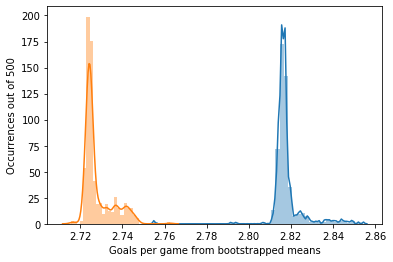

In [8]:
sns.distplot(np.array(bootstrap_means_before), norm_hist=True)
sns.distplot(np.array(bootstrap_means_after), norm_hist=True)
plt.ylabel('Occurrences out of 500');
plt.xlabel('Goals per game from bootstrapped means');


In [9]:
stats.ttest_ind(bootstrap_means_before, bootstrap_means_after)

Ttest_indResult(statistic=194.4564414490776, pvalue=0.0)

Ok so...not the same. Clearly not the same.

# Let's look at ages now

#### H0: There is *not* a statistically significant point decrease in forwards once they've turned 31.

#### Ha: There is a statistically significant point decrease in forwards once they've turned 31.

In [10]:
# Quick DataFrame cleanup.  Here we are looking at scoring points, so we
# are purposefully not looking at defensemen.  They are dropped from the
# DataFrame.

df = df.drop('Unnamed: 0', axis = 1)
d_men = df[df.Pos == " D "].index
df.drop(d_men, inplace=True)

df.head(10)

,Season,Player,Age,Tm,Pos,GP,G,GPG,A,PTS,...,SHA,S,S%,TOI,ATOI,BLK,HIT,FOwin,FOloss,FO%
0,2018,Justin Abdelkader,30.0,DET,LW,75,13,0.1733,22,35,...,-,110,12,"1,241",16:33,40.0,174.0,47.0,50.0,48.5
1,2018,Pontus Aberg,24.0,TOT,LW,53,4,0.0755,12,16,...,-,70,6,645,12:10,8.0,24.0,4.0,8.0,33.3
2,2018,Noel Acciari,26.0,BOS,C,60,10,0.1667,1,11,...,-,66,15,775,12:55,41.0,152.0,42.0,51.0,45.2
3,2018,Kenny Agostino,25.0,BOS,LW,5,-,0.0000,1,1,...,-,11,-,60,12:03,1.0,4.0,0.0,1.0,0.0
4,2018,Sebastian Aho,20.0,CAR,RW,78,29,0.3718,36,65,...,-,200,15,"1,398",17:55,17.0,65.0,78.0,94.0,45.3
8,2018,Michael Amadio,21.0,LAK,C,37,4,0.1081,4,8,...,-,28,14,345,9:19,9.0,18.0,74.0,96.0,43.5
9,2018,Josh Anderson,23.0,CBJ,RW,63,19,0.3016,11,30,...,-,188,10,"1,136",18:02,24.0,109.0,26.0,36.0,41.9
10,2018,Lias Andersson,19.0,NYR,C,7,1,0.1429,1,2,...,-,5,20,84,11:57,3.0,9.0,19.0,28.0,40.4
12,2018,Andy Andreoff,26.0,LAK,LW,45,3,0.0667,6,9,...,-,47,6,423,9:23,11.0,77.0,24.0,29.0,45.3
13,2018,Sven Andrighetto,24.0,COL,RW,50,8,0.1600,14,22,...,-,111,7,724,14:29,18.0,38.0,7.0,15.0,31.8


In [11]:
# Good, D-men are dropped.
df.Pos.unique()

array([' LW ', ' C ', ' RW ', ' RW/LW ', ' LW/RW ', ' RW/C ', ' C/LW ',
       ' LW/C ', ' LW/D ', ' RW/D ', ' C/RW ', ' C/RW/ ', ' D/LW ',
       ' C/LW/ ', ' D/RW ', ' F ', ' W/D ', ' W ', ' C/D '], dtype=object)

In [12]:
# Initializing variables
players_30 = []
df_30 = df.loc[df.Age == 30.0]
df_31 = df.loc[df.Age == 31.0]
series_30 = df_30.Player
series_31 = df_31.Player
player_dict_30 = {}
player_dict_31 = {}

# The csv includes asterisks after some player names.  The next two
# for loops remove these asterisks and add {name: [points, games]} as a
# new dictionary entry

for key30, value30 in series_30.iteritems():
    if value30 not in player_dict_30.keys():
        if value30.endswith('*'):
            player_dict_30[value30[:-1]] = df.loc[key30, ['PTS', 'GP']]
        else:
            player_dict_30[value30] = df.loc[key30, ['PTS', 'GP']]
            
for key31, value31 in series_31.iteritems():
    if value31 not in player_dict_31.keys():
        if value31.endswith('*'):
            player_dict_31[value31[:-1]] = df.loc[key31, ['PTS', 'GP']]
        else:
            player_dict_31[value31] = df.loc[key31, ['PTS', 'GP']]

In [13]:
# Good it worked.
player_dict_31

{'Mike Blunden': PTS     -   
 GP         1
 Name: 67, dtype: object, 'Jared Boll': PTS     1 
 GP      10
 Name: 71, dtype: object, 'Tyler Bozak': PTS     43 
 GP       81
 Name: 87, dtype: object, 'Blake Comeau': PTS     34 
 GP       79
 Name: 152, dtype: object, 'David Desharnais': PTS     28 
 GP       71
 Name: 192, dtype: object, 'Derek Dorsett': PTS     9 
 GP      20
 Name: 202, dtype: object, 'Brandon Dubinsky': PTS     16 
 GP       62
 Name: 208, dtype: object, 'Micheal Haley': PTS     9 
 GP      75
 Name: 329, dtype: object, 'Jannik Hansen': PTS     14 
 GP       46
 Name: 338, dtype: object, 'Darren Helm': PTS     31 
 GP       75
 Name: 353, dtype: object, 'Patric Hornqvist': PTS     49 
 GP       70
 Name: 373, dtype: object, 'Leo Komarov': PTS     19 
 GP       74
 Name: 442, dtype: object, 'David Krejci': PTS     44 
 GP       64
 Name: 447, dtype: object, 'Nikolai Kulemin': PTS     3 
 GP      13
 Name: 455, dtype: object, 'Trevor Lewis': PTS     26 
 GP       68
 N

In [14]:
player_dict_30['Justin Abdelkader'][1]

75

In [15]:
# Initialize variables
dict_diff = {}
ppg30 = 0
ppg31 = 0

# Making all point totals int values.  Also correctly changes point
# values from ' -  ' to 0.
for key,value in player_dict_30.items():
    if value.PTS == ' -   ':
        value.PTS = 0
    else:
        value.PTS = int(value.PTS)

for key,value in player_dict_31.items():
    if value.PTS == ' -   ':
        value.PTS = 0
    else:
        value.PTS = int(value.PTS)

# If the name exists in our 30-year-old player dictionary and our
# 31-year-old player dictionary, then we calculate points per game for
# each and enter {name: [ppg at 30, ppg at 31]} as a new dictionary entry.
for key30, value30 in player_dict_30.items():
    if key30 in player_dict_31.keys():
        ppg30 = (value30.PTS/value30.GP)
        ppg31 = (player_dict_31[key30].PTS/player_dict_31[key30].GP)
        dict_diff[key30] = [ppg30, ppg31]
#     else:
#         continue

In [16]:
# Initialize values
dict_30_ppg = []
dict_31_ppg = []

# Make 30-year-old ppg list and 31-year-old ppg list for direct
# comparison
for key, value in dict_diff.items():
    dict_30_ppg.append(value[0])
    dict_31_ppg.append(value[1])

# Paired t-test
stats.ttest_rel(dict_30_ppg, dict_31_ppg)


Ttest_relResult(statistic=7.556196786277496, pvalue=1.0173574094877106e-13)

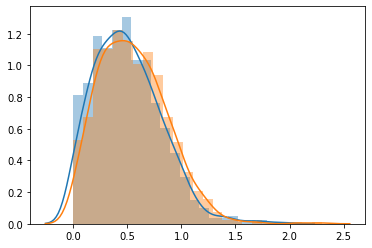

In [17]:
# More eda, checking distributions
sns.distplot(dict_31_ppg)
sns.distplot(dict_30_ppg)

In [18]:
# Quick Cohen's d function to check importance

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.average(x) - np.average(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [19]:
cohen_d(dict_30_ppg, dict_31_ppg)

0.1639942746802788

The above shows a small importance, even though there was a statistical significance from earlier.  So, while we can confidently say that point totals do drop as players age from 30 to 31, the result isn't so important.

In [20]:
cohen_d(bootstrap_means_after, bootstrap_means_before)

-12.298505213405171

MASSIVELY important.  However, this wasn't statistically significant for our tests.  Originally, we expected the rule changes to make scores go UP.  According to our tests, scores went DOWN.  Also, we find this data a bit suspicious since it is based on bootstrapped sample means.

In [21]:
cohen_d(listofgoalgpgBefore, listofgoalgpgAfter)


0.28737943313414793

This represents a medium importance level.  But again, this is in the wrong direction according to our hypothesis.

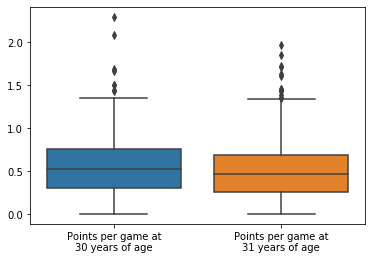

In [22]:
# Showing the tiny drop off in points per game.  The outliers are a 
# little more drastic, but outliers tend to be drastic anyway.
sns.boxplot( x=['Points per game at\n30 years of age', 'Points per game at\n31 years of age'], y=[dict_30_ppg, dict_31_ppg]);